In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns

In [2]:
def get_prob_sess(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    probs = behavioral_utils.get_prob_correct_by_block_pos(valid_beh, 20)
    probs["session"] = session
    return probs

In [3]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
sam_res = pd.concat(sessions.apply(lambda x: get_prob_sess(x, beh_path), axis=1).values)
sam_res["subject"] = "Monkey S"

In [4]:
# Monkey B
sessions = pd.DataFrame({"session_name": [20190123, 20190124, 20190125, 20190128, 20190312, 20190313, 20190329]})
beh_path = "/data/rawdata/sub-BL/sess-{sess_name}/behavior/sub-BL_sess-{sess_name}_object_features.csv"
blanche_res = pd.concat(sessions.apply(lambda x: get_prob_sess(x, beh_path), axis=1).values)
blanche_res["subject"] = "Monkey B"

In [5]:
# RL agents
# agent_names = ["optimal_agent", "two_step_block_switching", "two_step_block_switching_prob", "two_step_block_switching_prob0.75"]
# subject_names = ["Optimal", "Deterministic", "Prob 0.8", "Prob 0.75"]
agent_names = [
    "two_step_block_switching", 
    "two_step_block_switching_prob0.75", 
    # "shared_belief_rnn_prob_matches_sam_0", 
    # "separate_belief_rnn_prob_matches_sam_0",
    "shared_belief_rnn_prob_matches_sam_0_beta_0.75", 
    "separate_belief_rnn_prob_matches_sam_0_beta_0.75"
]
subject_names = ["Deterministic", "Prob 0.75", "Shared Matching", "Separate Matching"]
beh_dir = "/data/patrick_res/rl/beh"
agent_reses = []
for i, agent_name in enumerate(agent_names):
    session_name = "{sess_name}"
    beh_path = f"/data/patrick_res/rl/beh/{agent_name}_session_{session_name}.csv"
    sessions = pd.DataFrame({"session_name": np.arange(10)})
    agent_res = pd.concat(sessions.apply(lambda x: get_prob_sess(x, beh_path), axis=1).values)
    agent_res["subject"] = subject_names[i]
    agent_reses.append(agent_res)

In [6]:
res = pd.concat(agent_reses + [sam_res, blanche_res])

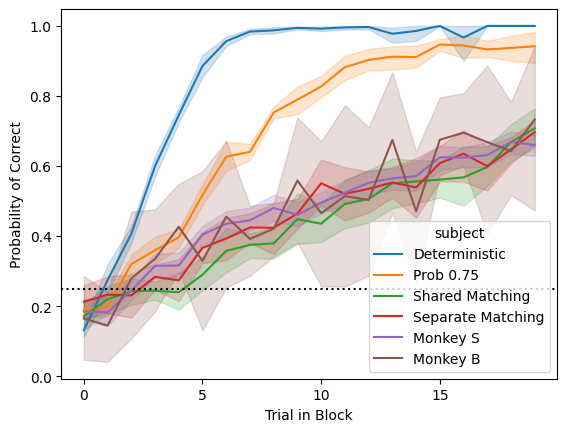

In [7]:
fig, ax = plt.subplots()
sns.lineplot(data=res, x="TrialInBlock", y="ProbCorrect", hue="subject", ax=ax)
ax.set_xlabel("Trial in Block")
ax.set_ylabel("Probability of Correct") 
ax.set_xticks([0, 5, 10, 15])
ax.set_xticklabels([0, 5, 10, 15])
ax.axhline(0.25, color='black', linestyle='dotted', label="Chance")


### Plot a version with no prob models

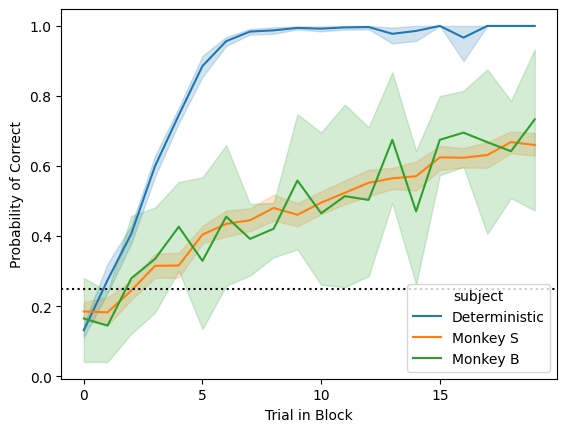

In [8]:
fig, ax = plt.subplots()
sub_res = res[res.subject.isin(["Optimal", "Deterministic", "Monkey S", "Monkey B"])]
sns.lineplot(data=sub_res, x="TrialInBlock", y="ProbCorrect", hue="subject", ax=ax)
ax.set_xlabel("Trial in Block")
ax.set_ylabel("Probability of Correct") 
ax.set_xticks([0, 5, 10, 15])
ax.set_xticklabels([0, 5, 10, 15])
ax.axhline(0.25, color='black', linestyle='dotted', label="Chance")


### Plot block lengths

In [9]:
def get_block_lengths(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)
    valid_beh = behavioral_utils.get_valid_trials(beh)
    return valid_beh.groupby("BlockNumber").TrialNumber.nunique().values

def avg_reward_rate(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)
    valid_beh = behavioral_utils.get_valid_trials(beh)
    return len(valid_beh[valid_beh.Response == "Correct"]) / len(valid_beh)

In [10]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
sam_res = np.concatenate(sessions.apply(lambda x: get_block_lengths(x, beh_path), axis=1).values)
sam_reward_res = sessions.apply(lambda x: avg_reward_rate(x, beh_path), axis=1)

In [11]:
# Monkey B
sessions = pd.DataFrame({"session_name": [20190123, 20190124, 20190125, 20190128, 20190312, 20190313, 20190329]})
beh_path = "/data/rawdata/sub-BL/sess-{sess_name}/behavior/sub-BL_sess-{sess_name}_object_features.csv"
blanche_res = np.concatenate(sessions.apply(lambda x: get_block_lengths(x, beh_path), axis=1).values)
blanche_reward_res = sessions.apply(lambda x: avg_reward_rate(x, beh_path), axis=1)

In [22]:
# RL agents
# agent_names = ["optimal_agent", "two_step_block_switching", "two_step_block_switching_prob", "two_step_block_switching_prob0.75"]
# agent_subject_names = ["Optimal", "Deterministic", "Prob 0.8", "Prob 0.75"]

# agent_names = ["optimal_agent", "two_step_block_switching"]
# agent_subject_names = ["Optimal", "RNN"]

agent_names = ["optimal_agent", "two_step_block_switching", "fitted_feature_rl", "fitted_belief_state_agent", "shared_belief_rnn_prob_matches_sam_0_beta_0.75"]
agent_subject_names = ["Optimal", "Optimal RNN", "Feature RL", "Belief State", "Matching RNN"]

# agent_names = [
#     "two_step_block_switching", 
#     "two_step_block_switching_prob0.75", 
#     # "shared_belief_rnn_prob_matches_sam_0", 
#     # "separate_belief_rnn_prob_matches_sam_0",
#     "shared_belief_rnn_prob_matches_sam_0_beta_0.75", 
#     "separate_belief_rnn_prob_matches_sam_0_beta_0.75",
# ]
# agent_subject_names = ["Deterministic", "Prob 0.75", "Shared Matching", "Separate Matching"]
beh_dir = "/data/patrick_res/rl/beh"
agent_reses = []
agent_reward_reses = []
for i, agent_name in enumerate(agent_names):
    session_name = "{sess_name}"
    beh_path = f"/data/patrick_res/rl/beh/{agent_name}_session_{session_name}.csv"
    sessions = pd.DataFrame({"session_name": np.arange(10)})
    agent_res = np.concatenate(sessions.apply(lambda x: get_block_lengths(x, beh_path), axis=1).values)
    agent_reses.append(agent_res)
    agent_reward_reses.append(sessions.apply(lambda x: avg_reward_rate(x, beh_path), axis=1))


In [23]:
# subject_names = agent_subject_names + ["Monkey S", "Monkey B"]
# reses = agent_reses + [sam_res, blanche_res]

subject_names = agent_subject_names + ["Monkey S"]
reses = agent_reses + [sam_res]

[Text(0, 0, 'Optimal'),
 Text(1, 0, 'Optimal RNN'),
 Text(2, 0, 'Feature RL'),
 Text(3, 0, 'Belief State'),
 Text(4, 0, 'Matching RNN'),
 Text(5, 0, 'Monkey S')]

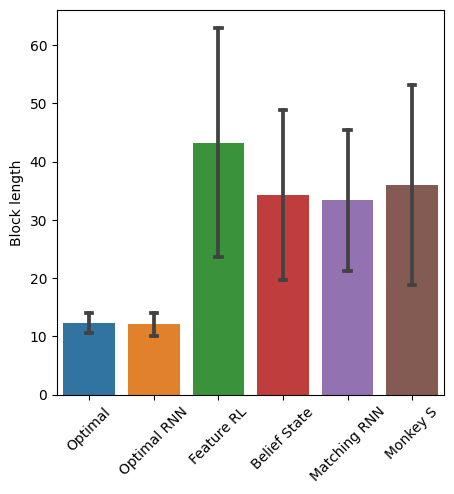

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=reses, capsize=.1, errorbar='sd', ax=ax)
# sns.swarmplot(data=reses, color="0", alpha=.35, ax=ax)

ax.set_xticklabels(subject_names)
ax.set_ylabel("Block length")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


[Text(0, 0, 'Optimal'),
 Text(1, 0, 'Optimal RNN'),
 Text(2, 0, 'Feature RL'),
 Text(3, 0, 'Belief State'),
 Text(4, 0, 'Matching RNN'),
 Text(5, 0, 'Monkey S')]

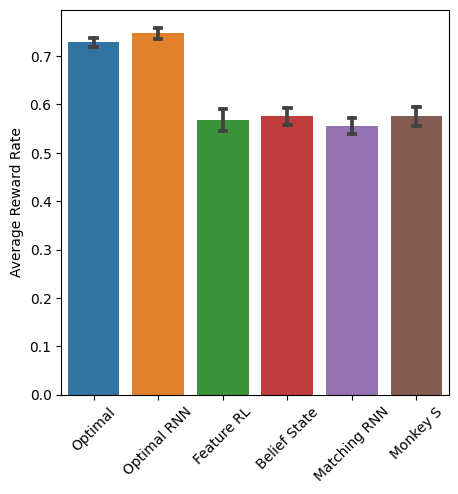

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))
# reward_reses = agent_reward_reses + [sam_reward_res, blanche_reward_res]
reward_reses = agent_reward_reses + [sam_reward_res]

sns.barplot(data=reward_reses, capsize=.1, errorbar='sd', ax=ax)
ax.set_xticklabels(subject_names)
ax.set_ylabel("Average Reward Rate")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


### No prob models

In [41]:
subject_names = agent_subject_names[:2] + ["Monkey S", "Monkey B"]
reses = agent_reses[:2] + [sam_res, blanche_res]

[Text(0, 0, 'Optimal'),
 Text(1, 0, 'Deterministic'),
 Text(2, 0, 'Monkey S'),
 Text(3, 0, 'Monkey B')]

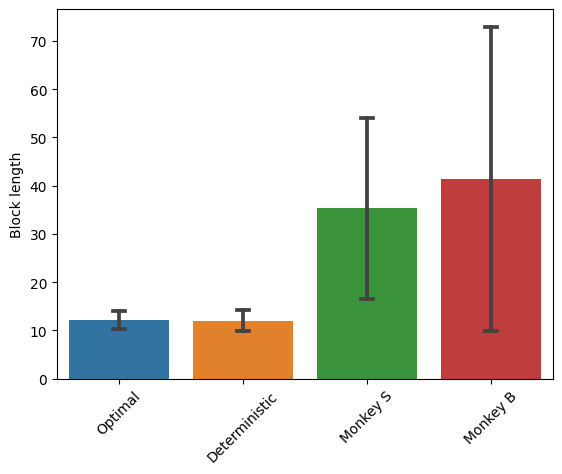

In [42]:
fig, ax = plt.subplots()
sns.barplot(data=reses, capsize=.1, errorbar='sd', ax=ax)
ax.set_xticklabels(subject_names)
ax.set_ylabel("Block length")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


### Plot a gif of feature values within a block

In [19]:
session = 20180802
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)
beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(beh)
beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
beh = behavioral_utils.get_feature_values_per_session(session, beh)
block = beh[beh.BlockNumber == 8]


In [20]:
block

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,TRIANGLEValue,CYANValue,GREENValue,MAGENTAValue,YELLOWValue,ESCHERValue,POLKADOTValue,RIPPLEValue,SWIRLValue,MaxFeat
166,201,8,0,NaN,917,Incorrect,3.0,8,CIRCLE,SQUARE,...,-0.086062,0.150971,0.349988,0.103317,0.113578,0.181299,0.181007,0.100406,0.055992,SQUARE
167,202,8,1,NaN,835,Incorrect,3.0,8,CIRCLE,SQUARE,...,-0.062298,0.022579,0.253345,0.074788,0.082215,0.052908,0.131025,0.072681,0.040531,SQUARE
168,203,8,2,NaN,802,Incorrect,1.0,8,CIRCLE,SQUARE,...,-0.045095,0.016344,0.183388,0.054136,-0.012693,0.038298,0.036117,0.052611,0.029339,GREEN
169,204,8,3,NaN,1027,Incorrect,3.0,8,CIRCLE,SQUARE,...,-0.070930,0.011831,0.157553,0.039188,-0.009188,0.027723,0.026144,0.026776,0.021238,SQUARE
170,205,8,4,NaN,973,Incorrect,2.0,8,CIRCLE,SQUARE,...,-0.051344,0.008564,0.114047,0.028367,-0.050082,0.020068,0.018925,-0.014118,0.015373,MAGENTA
171,206,8,5,NaN,623,Incorrect,3.0,8,CIRCLE,SQUARE,...,-0.037166,0.006199,0.082555,0.025450,-0.036253,0.014526,0.013699,-0.017035,0.011128,SQUARE
172,207,8,6,NaN,726,Incorrect,3.0,8,CIRCLE,SQUARE,...,-0.026903,0.004488,0.059759,0.018422,-0.057186,-0.006407,0.009916,-0.012331,0.008055,SQUARE
173,208,8,7,NaN,678,Correct,0.0,8,CIRCLE,SQUARE,...,-0.019475,-0.018250,0.043258,0.013335,-0.041395,-0.004637,0.007178,-0.008926,-0.014682,CIRCLE
174,209,8,8,NaN,850,Incorrect,2.0,8,CIRCLE,SQUARE,...,-0.018770,0.199442,0.041692,0.012853,-0.039897,0.213055,0.006918,-0.008603,-0.014151,CYAN
175,210,8,9,NaN,672,Correct,0.0,8,CIRCLE,SQUARE,...,-0.013587,0.171216,0.030180,0.009304,-0.028880,0.154224,-0.021308,-0.006228,-0.010243,CYAN


/tmp/ipykernel_929389/1508423736.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


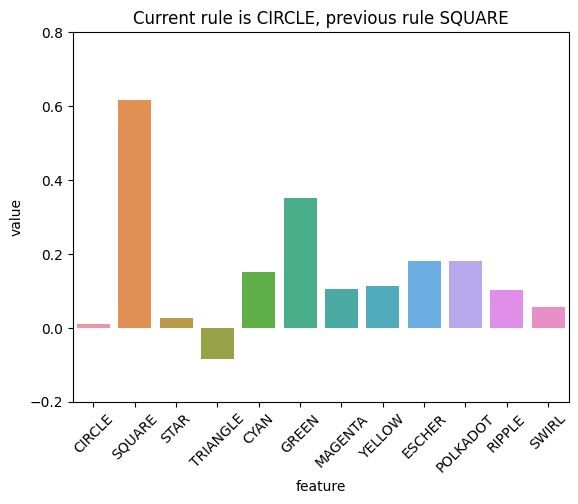

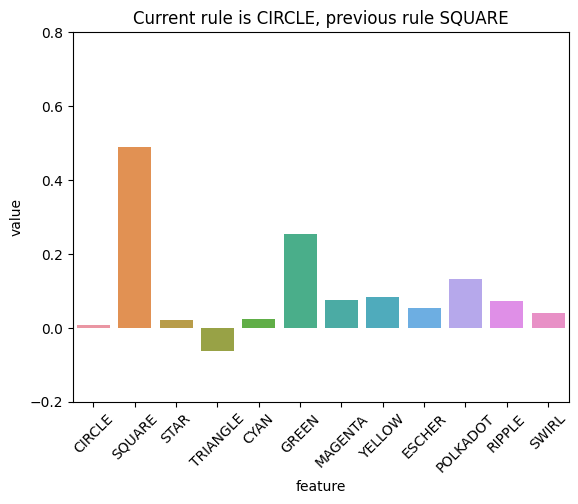

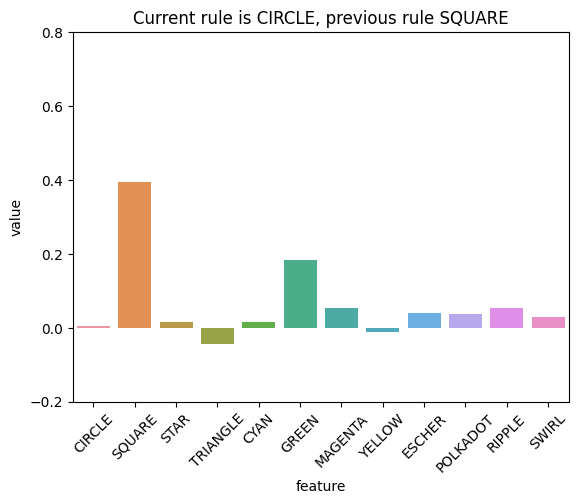

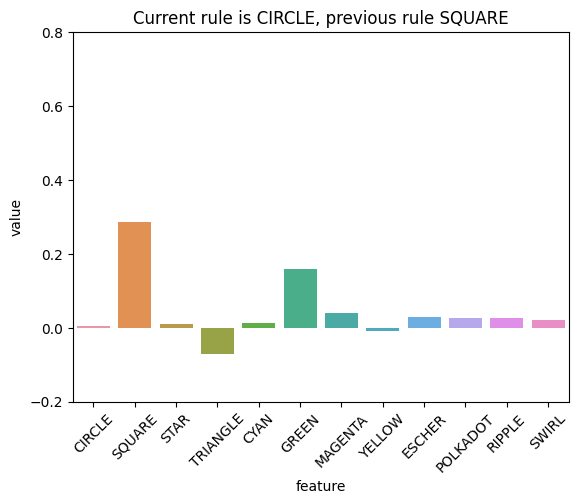

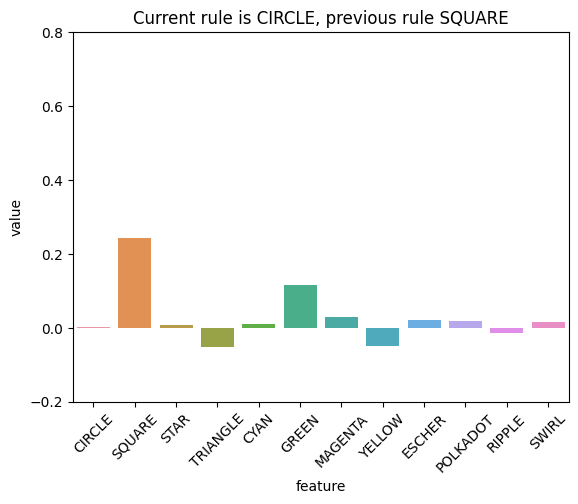

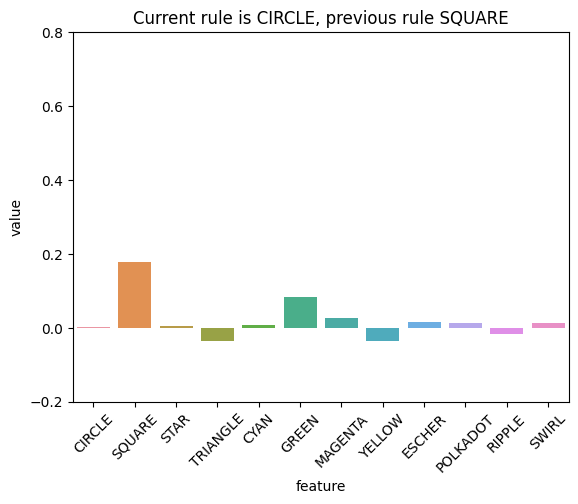

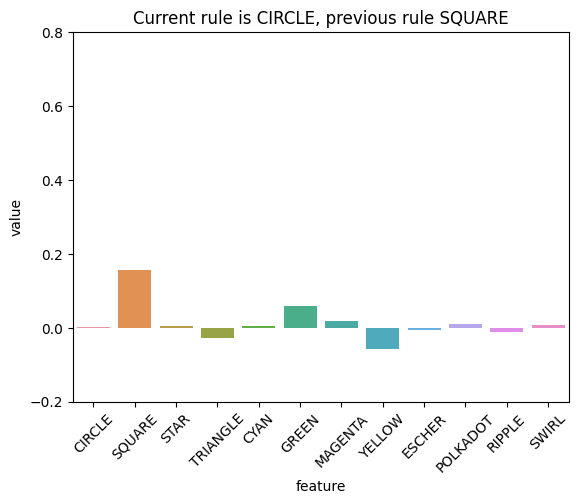

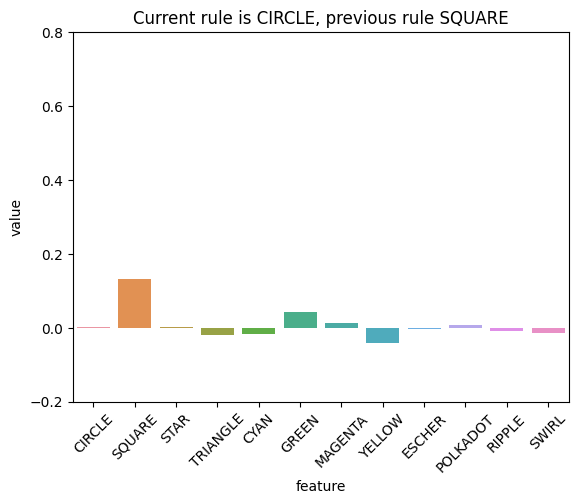

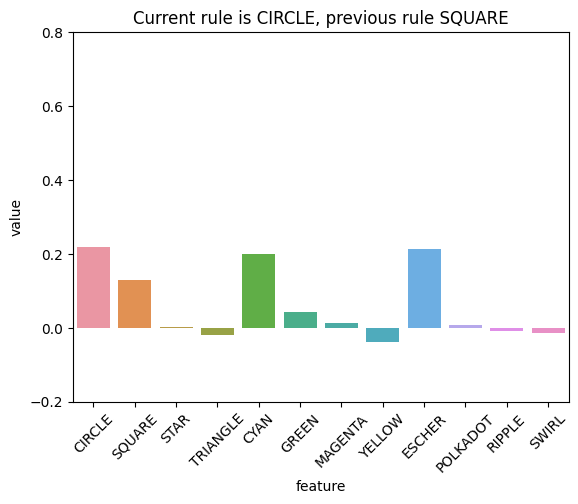

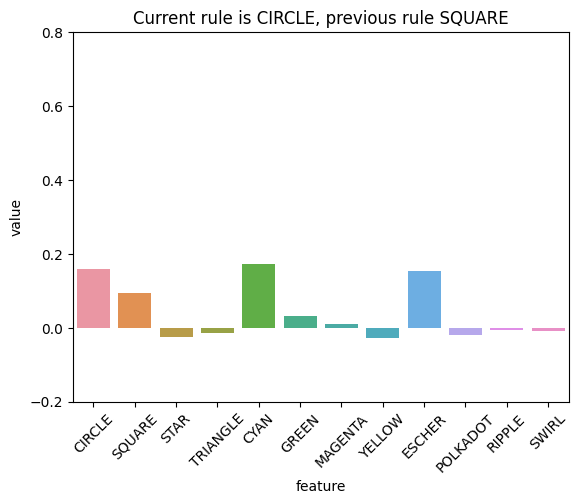

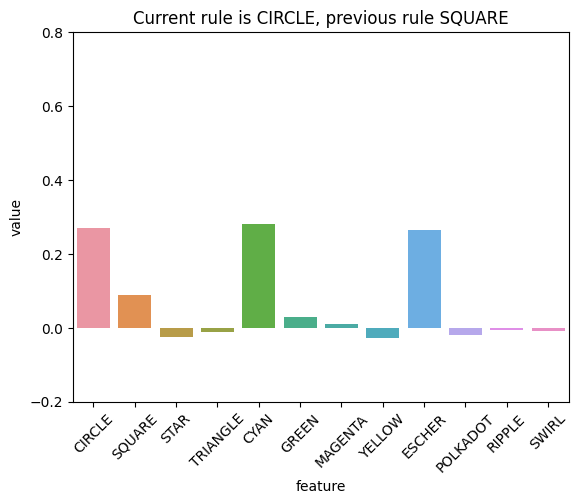

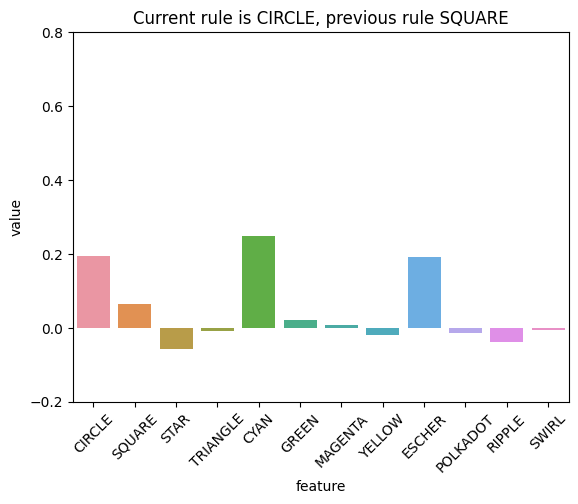

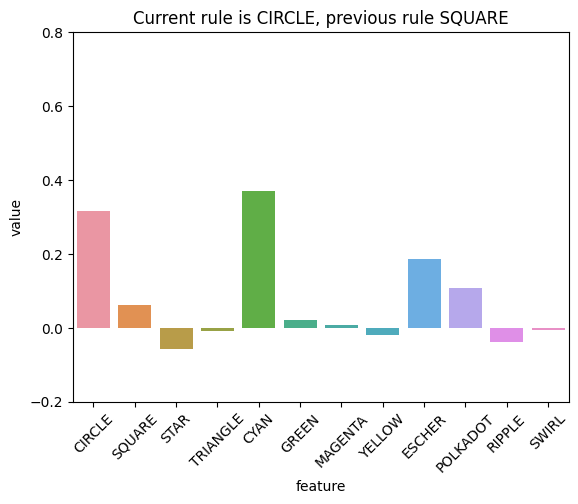

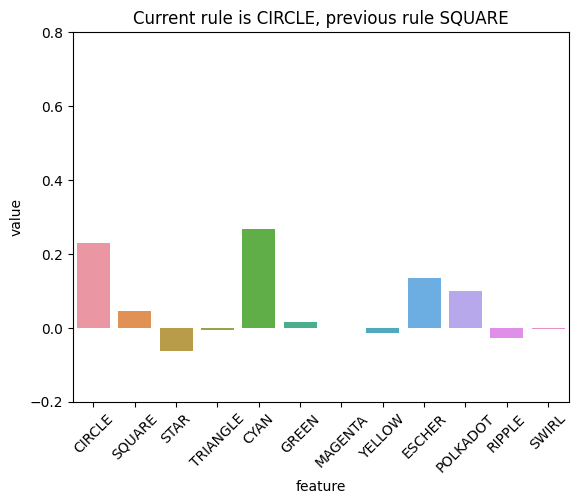

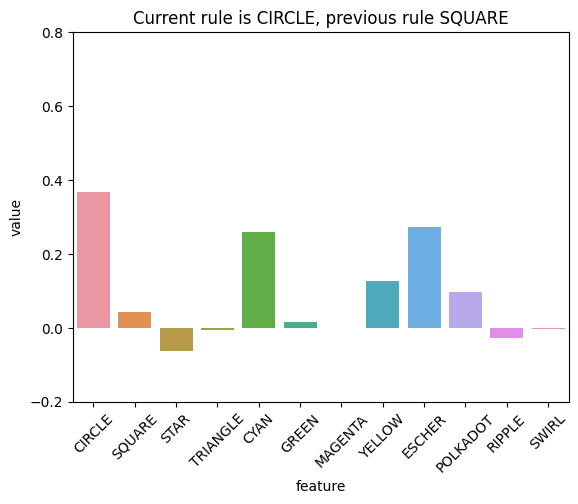

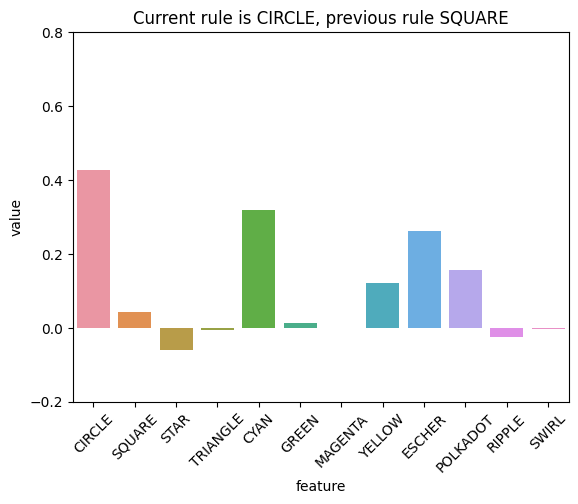

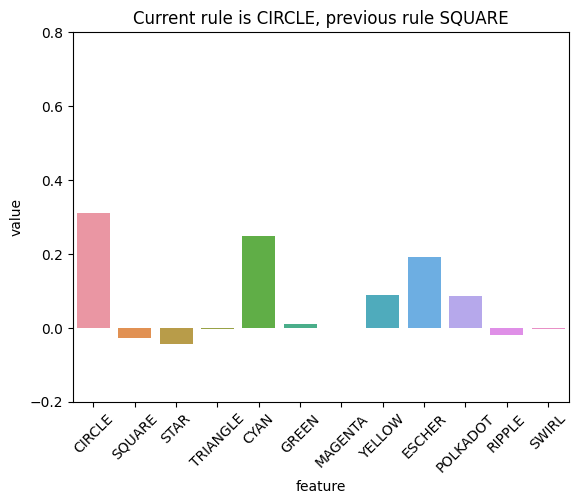

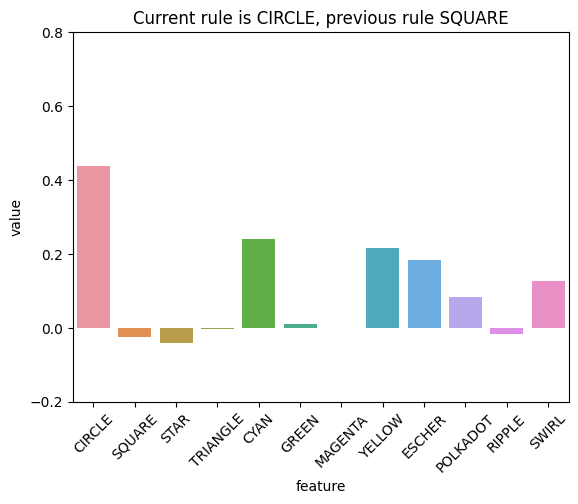

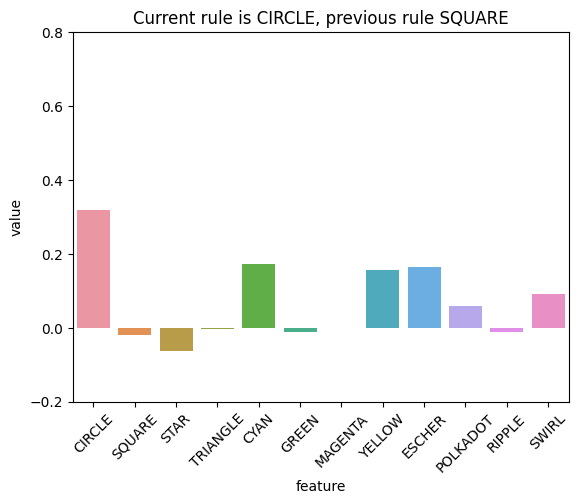

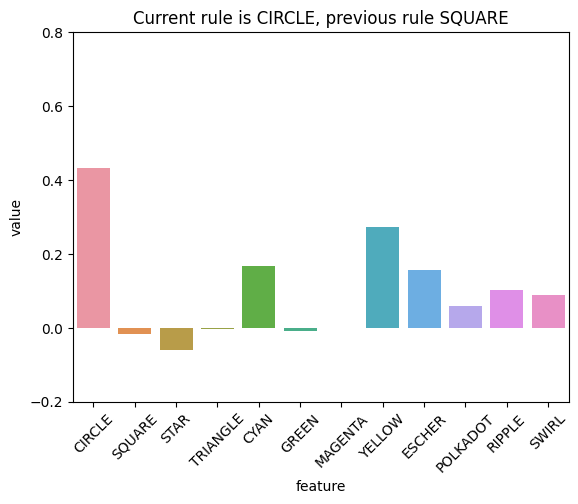

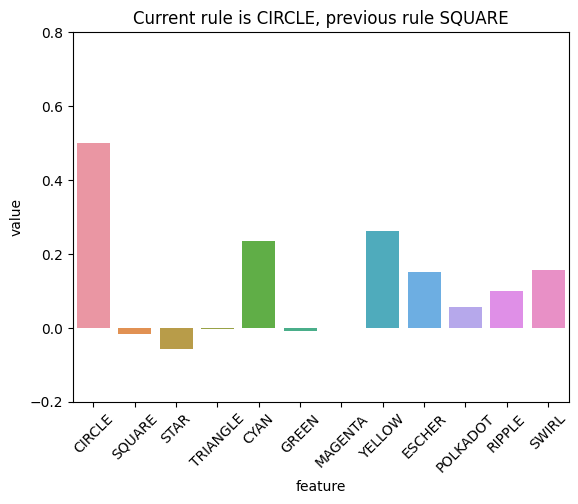

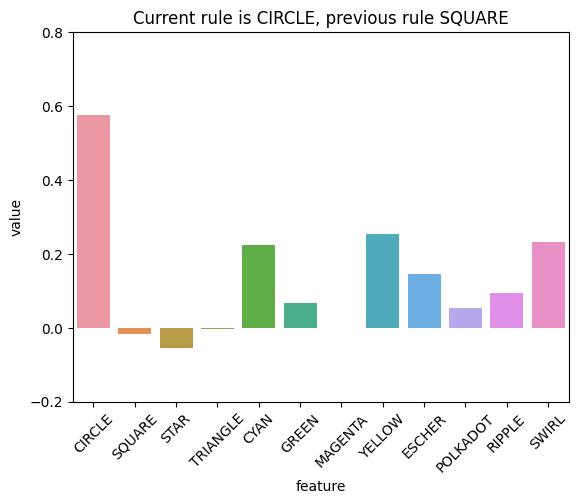

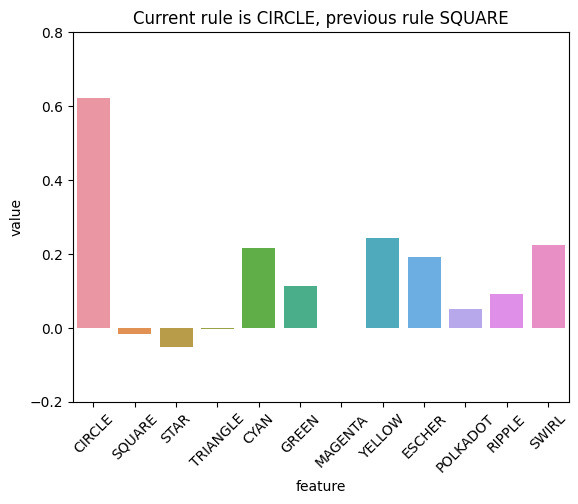

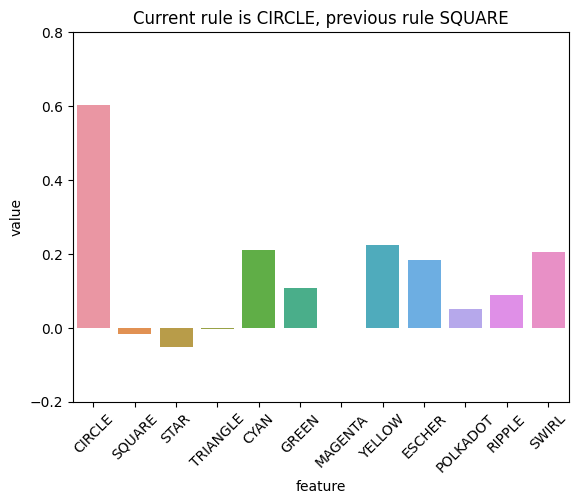

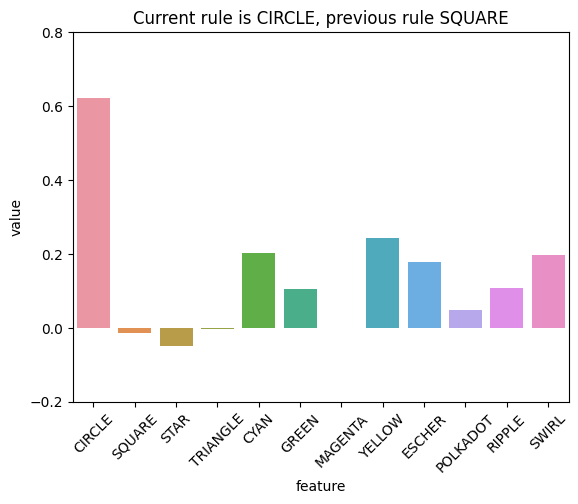

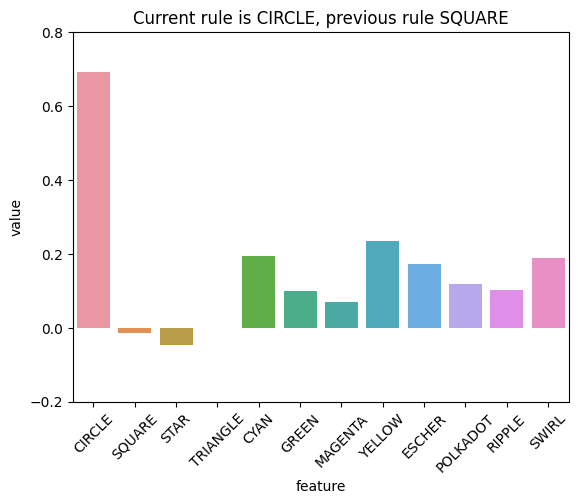

In [22]:
for i, row in block.iterrows():
    fig, ax = plt.subplots()

    res_df = row.to_frame().T
    rename_map = {f"{feat}Value": feat for feat in FEATURES}
    res_df = res_df.rename(columns=rename_map)
    melted = pd.melt(res_df, value_vars=FEATURES, var_name="feature", value_name="value")
    visualization_utils.plot_bars_by_cat(melted, "value", "feature", ax, order=FEATURES)
    ax.set_ylim([-0.2, 0.8])
    ax.set_title("Current rule is CIRCLE, previous rule SQUARE")
    fig.savefig(f"/data/patrick_res/figures/value_gif/{row.TrialAfterRuleChange}.png")